Дурыманов Евгений Валерьевич, отчет по алгоритму ДГГ.

In [3]:
import bisect
import sys
from test_functions import test_functions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
rec = 100000
sys.setrecursionlimit(rec)

In [5]:
def F(f, fdot, dots, x, m):
    new_index = bisect.bisect_right(dots[: -1], [x, float("inf"), 0, 0])
    #new index - 1, new index
    b, a = dots[new_index][0], dots[new_index - 1][0]
    y = y_ed(f, fdot, b, a, m)
    y_cup = y_ed_cup(f, fdot, b, a, m)
    if a <= x < y_cup:
        return f(a) + fdot(a) * (x - a) - (m / 2) * ((x - a) ** 2)
    elif y_cup <= x < y:
        temp_1 = fdot(b) - 2 * m * y + m * b
        temp_2 = f(b) - fdot(b) * b - 0.5 * m * (b ** 2) + m * (y ** 2)
        return 0.5 * m * (x ** 2) + temp_1 * x + temp_2
    elif y <= x <= b:
        return f(b) - fdot(b) * (b - x) - (m / 2) * ((b - x) ** 2)

In [6]:
def d_ed(f, fdot, b, a):
    temp_1 = (2 * (f(a) - f(b)) + (fdot(b) + fdot(a)) * (b - a)) ** 2
    temp_2 = ((fdot(b) - fdot(a)) ** 2) * ((b - a) ** 2)
    return (temp_1 + temp_2) ** (1 / 2)

In [7]:
def v_ed(f, fdot, b, a):
    d = d_ed(f, fdot, b, a)
    temp_1 = abs(2 * (f(a) - f(b)) + (fdot(b) + fdot(a)) * (b - a)) + d
    temp_2 = (b - a) ** (2)
    return temp_1 / temp_2

In [8]:
def y_ed(f, fdot, b, a, m):
    temp_1 = (b - a) / 4
    temp_2 = (fdot(b) - fdot(a)) / (4 * m)
    temp_3 = f(a) - f(b) + fdot(b) * b - fdot(a) * a + (0.5 * m * ((b ** 2) - (a ** 2)))
    temp_4 = m * (b - a) + fdot(b) - fdot(a)
    return temp_1 + temp_2 + (temp_3/temp_4)

In [9]:
def y_ed_cup(f, fdot, b, a, m):
    temp_1 = (b - a) / 4
    temp_2 = (fdot(b) - fdot(a)) / (4 * m)
    temp_3 = f(a) - f(b) + fdot(b) * b - fdot(a) * a + (0.5 * m * ((b ** 2) - (a ** 2)))
    temp_4 = m * (b - a) + fdot(b) - fdot(a)
    return -temp_1 - temp_2 + (temp_3/temp_4)

In [10]:
def pi_dot(fdot, y, m, b, a):
    return fdot(b) - m * (y - b)

In [11]:
def pi_dot_cup(fdot, y_cup, m, b, a):
    return fdot(a) - m * (y_cup - a)

In [12]:
def charred(f, fdot, y, m, b, a, case):
    if case == 0:
        c = f(b) - fdot(b) * b - 0.5 * m * (b ** 2) + m * (y ** 2)
        x_cup = 2 * y - fdot(b) * (m ** (-1)) - b
        psi = c - 0.5 * m * (x_cup ** 2)
        char = min(f(a), f(b), psi)
        return char, 1
    elif case == 1:
        char = min(f(a), f(b))
        if f(a) < f(b):
            return char, 0
        else:
            return char, 2

In [13]:
#dots(dot, char, v, char_class)

def dgg(f, dots, fdot, v_max_index, counter):
    _, min_index, char_class = min([(y, i, cc) for i, (_, y, _, cc) in enumerate(dots)])

    if abs(dots[min_index + 1][0] - dots[min_index][0]) < epsilon_stop:
        func_values = [f(x) for (x, _, _, _) in dots]
        return min(func_values), max(epsilon, dots[v_max_index][2]) * tau, counter

    counter += 1

    v_max = dots[v_max_index][2]
    m_start = tau * max(epsilon, v_max)

    if char_class == 0:
        new_dot = y_ed_cup(f, fdot, dots[min_index + 1][0], dots[min_index][0], m_start)
    elif char_class == 1:
        y = y_ed(f, fdot, dots[min_index + 1][0], dots[min_index][0], m_start)
        new_dot = (2 * y) - (fdot(dots[min_index + 1][0]) * (m_start ** (-1))) - dots[min_index + 1][0]
    else:
        new_dot = y_ed(f, fdot, dots[min_index + 1][0], dots[min_index][0], m_start)

    new_index = bisect.bisect_left(dots, [new_dot, float("inf"), -float("inf"), None])
    bisect.insort_left(dots, [new_dot, float("inf"), -float("inf"), None])

    v_1 = v_ed(f, fdot, dots[new_index][0], dots[new_index - 1][0])
    v_2 = v_ed(f, fdot, dots[new_index + 1][0], dots[new_index][0])

    dots[new_index - 1][2], dots[new_index][2] = v_1, v_2

    v_finish, v_max_index = max([(v, -index) for index, (_, _, v, _) in enumerate(dots)])
    v_max_index *= (-1)
    m_finish = tau * max(v_finish, epsilon)

    m = m_finish

    if m_start == m_finish:

        for i in (0, 1):
            y_cup = y_ed_cup(f, fdot, dots[new_index + i][0], dots[new_index + i - 1][0], m)
            y = y_ed(f, fdot, dots[new_index + i][0], dots[new_index + i - 1][0], m)
            pi_1 = pi_dot_cup(fdot, y_cup, m, dots[new_index + i][0], dots[new_index + i - 1][0])
            pi_2 = pi_dot(fdot, y, m, dots[new_index + i][0], dots[new_index + i - 1][0])
            if (pi_1 * pi_2) >= 0:
                char, char_class = charred(f, fdot, y, m, dots[new_index + i][0], dots[new_index + i - 1][0], 1)
                dots[new_index - 1 + i][1], dots[new_index - 1 + i][3] = char, char_class
            else:
                char, char_class = charred(f, fdot, y, m, dots[new_index + i][0], dots[new_index + i - 1][0], 0)
                dots[new_index - 1 + i][1], dots[new_index - 1 + i][3] = char, char_class
        return dgg(f, dots, fdot, v_max_index, counter)

    else:

        for i in range(len(dots) - 1):
            y_cup = y_ed_cup(f, fdot, dots[i + 1][0], dots[i][0], m)
            y = y_ed(f, fdot, dots[i + 1][0], dots[i][0], m)
            pi_1 = pi_dot_cup(fdot, y_cup, m, dots[i + 1][0], dots[i][0])
            pi_2 = pi_dot(fdot, y, m, dots[i + 1][0], dots[i][0])
            if pi_1 * pi_2 >= 0:
                char, char_class = charred(f, fdot, y, m, dots[i + 1][0], dots[i][0], 1)
                dots[i][1], dots[i][3] = char, char_class
            else:
                char, char_class = charred(f, fdot, y, m, dots[i + 1][0], dots[i][0], 0)
                dots[i][1], dots[i][3] = char, char_class
        return dgg(f, dots, fdot, v_max_index, counter)

In [14]:
epsilon = 10 ** (-6)
tau = 1.5

1 -29763.23327849804 16
2 -1.8995993483269276 13
3 -12.03123490691888 66
4 -3.8504507087276614 15
5 -1.4890723376194732 16
6 -0.8242393979319379 24
7 -1.6013074861084569 13
8 -14.508007894780134 63
9 -1.9059610887737133 15
10 -7.916727249566752 11
11 -1.4999999729129763 30
12 -0.9999999851204582 23
13 -1.5874010517060477 80
14 -0.7886852547273806 19
15 -0.03553390555455304 35
16 7.515924265290283 64
17 7.000000000474216 48
18 9.272619059418579e-10 9
19 -7.8156745426359 11
20 -0.06349051961962802 22


In [ ]:
xarrays, yarrays, ogarrays = [], [], []
for index, func in enumerate(test_functions):
    x_arr = np.linspace(func.interval[0], func.interval[1], 1200)
    ys = []
    og = []
    f, fdot, a, b, L, counter = func.f, func.fdot, func.interval[0], func.interval[1], func.L, 0
    epsilon_stop = (b - a) * (10 ** -4)
    v = v_ed(f, fdot, b, a)
    m = tau * max(v, epsilon)
    y = y_ed(f, fdot, b, a, m)
    y_cup = y_ed_cup(f, fdot, b, a, m)
    pi = pi_dot(fdot, y, m, b, a)
    pi_cup = pi_dot_cup(fdot, y_cup, m, b, a)
    if (pi * pi_cup) >= 0:
        char, char_class = charred(f, fdot, y, m, b, a, 1)
    else:
        char, char_class = charred(f, fdot, y, m, b, a, 0)
    dots  = [[a, char, v, char_class], [b, float("inf"), -float("inf"), None]]
    minval, m, count = dgg(f, dots, fdot, 0, counter)
    print(index + 1, minval, count)
    for i in x_arr:
        ys.append(f(i))
        og.append(F(f, fdot, dots, i, m))
    xarrays.append(x_arr)
    yarrays.append(ys)
    ogarrays.append(og)

1. ДГГ - алгоритм, в таблице выше форматом "Номер тестовой функции", "Посчитанный минимум", "Количество итераций работы алгоритма".

2. Снизу отображены графики функции и огибающих ломаных:

- параметр остановки алгоритма: $x_t$ - $x_{t-1}$ < $(b - a) \times $$10^{-4}$, где b, a - граничные точки области определения функции, $x_t$ - точка испытания функции на следующем шаге алгоритма, $x_{t-1}$ - точка испытания ближайшая слева на оси абсцисс
- Параметр безопасности $\tau$ = 1.5

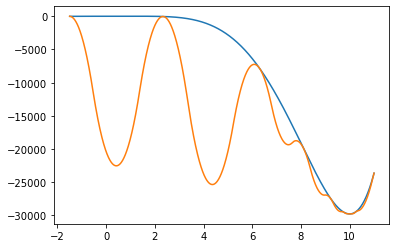

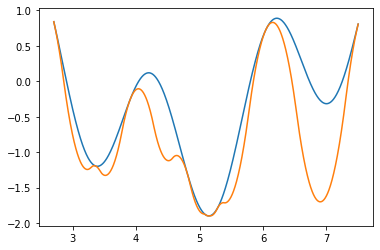

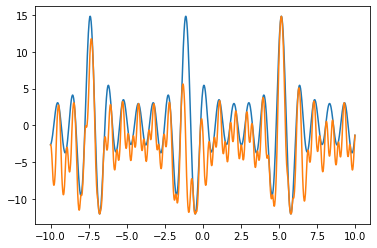

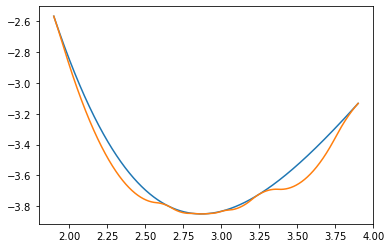

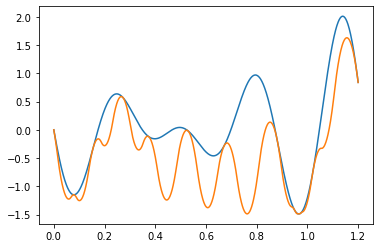

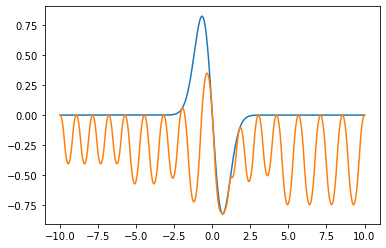

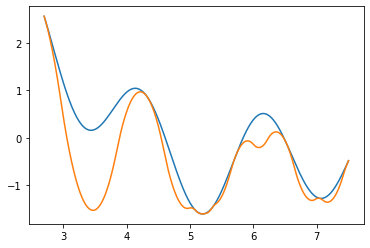

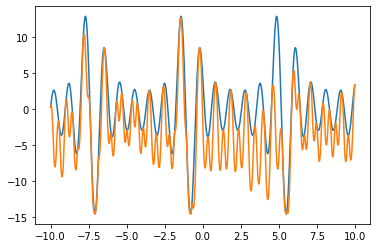

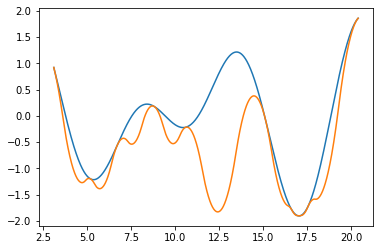

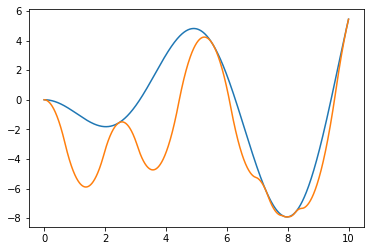

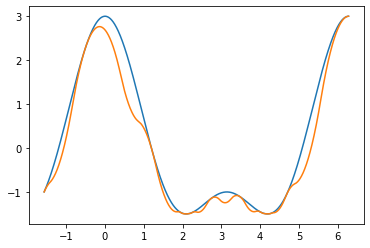

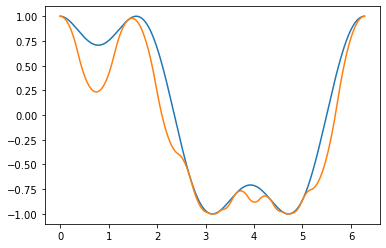

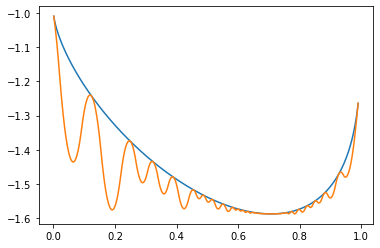

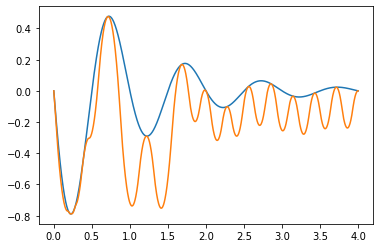

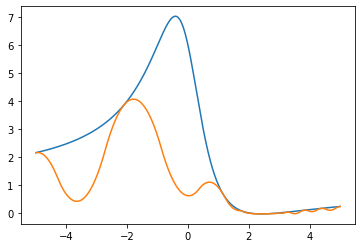

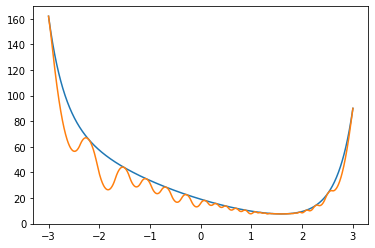

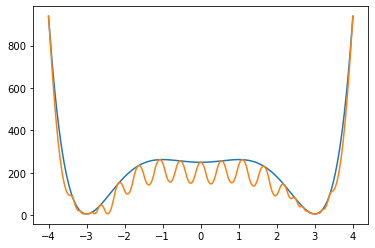

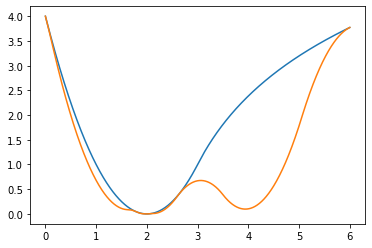

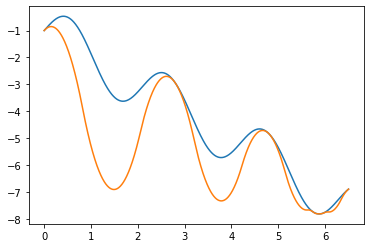

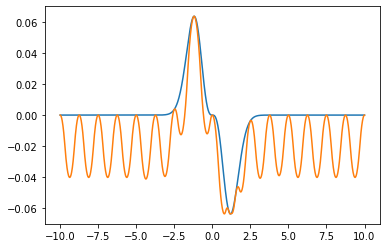

In [15]:
for index in range(20):
    plt.plot(xarrays[index], yarrays[index])
    plt.plot(xarrays[index], ogarrays[index])
    plt.show()